In [5]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
from tqdm import tqdm
# import jax
# import jax.numpy as jnp
# import autograd
# import autograd.numpy as anp
# import torch
import matplotlib.pyplot as plt

from matplotlib.ticker import MaxNLocator
from tqdm import tqdm

from scipy.optimize import minimize
import math


# Homework 4

This is a homework assignment on the material from the 5th week of classes. The deadline for submission is __23:59 on December 26__.

- The homework is done in the same Jupyter Notebook.

- The file should be renamed: __First Name_Last Name__ (no spaces at the beginning or end). Example: __Ivan_Ivanov__.

- Homework should be sent to __OptimizationHomework@yandex.ru__. Subject line: __Skoltech_Task number__ (without spaces at the beginning and end). For this assignment, the subject line is: __Skoltech_4__.

- Place the solution to each problem/item after the condition.

- Do not forget to add necessary explanations and comments.

- All technical artifacts should be removed in the final version that will be sent for checking. By such artifacts we mean any cell outputs that are not commented in any way in the text, as well as any bulk/long technical output (even if it is commented in the text).

- A full run of the solution (Kernel -> Restart & Run All) should run all cells without errors.

- The maximum score for the assignment is  115 + 40 (bonus). To get a full score for the hometask you need to get 100.

We wish you success!

### Part 1. Adaptive methods

Consider again the empirical risk minimization:
\begin{equation}
\min_{w \in \mathbb{R}^d} \frac{1}{n} \sum\limits_{i=1}^n \ell (g(w, x_i), y_i) + \frac{\lambda}{2} \| w\|^2_2,
\end{equation}
where $\ell: \mathbb{R} \times \mathbb{R} \to \mathbb{R}$ is a loss function, $g : \mathbb{R}^d \times \mathbb{R}^x \to \mathbb{R}$ is a model, $w$ are parameters of the model, $\{x_i, y_i\}_{i=1}^n$ is data of objects $x_i \in \mathbb{R}^x$ and labels $y_i \in \mathbb{R}$.

We use the linear model $g(w, x) = w^T x$ and the logistic/sigmoid loss function: $\ell(z,y) = \ln (1 + \exp(-yz))$ (__Important: $y$ must take values $-1$ or $1$__). As we already know, the resulting problem is called a logistic regression problem.

The gradient of $f$:
$$
\nabla f(w) = \frac{1}{n} \sum_{i=1}^n \frac{-y_{i} x_{i}}{1 + \exp(y_{i} w^Tx_{i})} + \lambda w.
$$
The Lipschitz constant of the gradient $\nabla f$ can be estimated as $L = \frac{1}{4n} \sum\limits_{i=1}^n \| x_{i} \|^2_2 + \lambda$.

Let us do some preparation work. The _mushrooms_ dataset is attached. Use the following code to generate a matrix $X$ and vector $y$, which will store the sample $\{x_i, y_i\}_{i=1}^n$:

In [697]:
dataset = "mushrooms.txt" 
#the file must be in the same directory as notebook.

In [698]:
from sklearn.datasets import load_svmlight_file
data = load_svmlight_file(dataset)
X, y = data[0].toarray(), data[1]

Let us change the vector $y$ so that $y_i$ takes values $-1$ and $1$. You can also do additional preprocessing of the data (with techniques from machine learning), but this is not additionally assessed in any way.

In [699]:
y = 2 * y - 3

Let us divide the data into two parts: training and test.

In [700]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

For the training part $X_{train}$, $y_{train}$, estimate the constant $L$. Set $\lambda$ such that $\lambda \approx L / 1000$.  Realize in the code the calculation of the value and gradient for our target function ($X$, $y$, $\lambda$ should be given as a parameter so that it is possible to change them, not only to substitute fixed $X_{train}$, $y_{train}$). You can use ``numpy``, or ``autograd``, ``pytorch``, ``jax``.

In [701]:
def lipschitz_constan(X):
    return np.sum(np.array([np.linalg.norm(x)**2 for x in X ])) * (1 / (4 * X.shape[0])) * 1000 / 999



# def function(X, y, lmbd, omega):

#     y = torch.from_numpy(y).float()
#     X = torch.from_numpy(X).float()
#     omega = torch.from_numpy(omega).float().requires_grad_(True)

#     return lmbd / 2 * torch.linalg.norm(omega)**2 +  torch.mean(torch.log(1 + torch.exp(-y @ X @ omega )))



def function(X, y, lmbd, omega):

    return lmbd / 2 * np.linalg.norm(omega)**2 +  np.mean([np.log(1 + np.exp(- y[i] * X[i] @ omega)) for i in range(X.shape[0])])


def analitical_grad(X, y, lmbd, omega):

    return lmbd * omega + np.mean([X[i] * -y[i]  * (1 / (1 + np.exp(y[i] * omega @ X[i]))) for i in range(X.shape[0])], axis=0)



# def function_grad(X, y, lmbd, omega):

#     y = torch.from_numpy(y).float()
#     X = torch.from_numpy(X).float()
#     omega = torch.from_numpy(omega).float().requires_grad_(True)

#     f = function(X, y, lmbd, omega)

#     f.backward()

#     return omega.grad

def grad_f(omega, X, y, lmbd):
    return np.mean((-y / (1 + np.exp(y * np.dot(X, omega))))[:, None] * X, axis=0) + lmbd * omega


__Problem. (65 points)__ This part of the assignment is related to adaptive methods.

__a). (25 points)__ When it comes to adaptive methods, the optimization community does not primarily think of methods like AdaGrad, Adam and others. The notion of adaptivity was initially interesting from the point of view of selecting a common step, not for each individual coordinate. For example, AdaGradNorm is one such method, but now we will look at adaptive step selection for smooth problems (recall that AdaGrad and AdaGradNorm were primarily motivated by the theory for non-smooth problems).

Consider the standard deterministic gradient descent method for the ERM problem:
$$
x^{k+1} = x^k - \gamma_k \nabla f(x^k)
$$
Before (in the previous homeworks) we used to take a step like $\gamma_k = \frac{1}{L}$. But the smoothness properties of the problem may vary from point to point and it is not necessary to evaluate $\gamma_k$ through the worst $L$.

Let us make the selection of the constant $L$ adaptive. It is possible to measure local $L$ using:
$$
f(y) \leq f(x^k) + \langle \nabla f(x^k), y - x^k \rangle + \frac{L}{2}\|x^k - y\|_2^2
$$
In particular, a procedure may be appropriate:

```python
def backtracking_L(f, grad, x, h, L0, rho):
    L = L0
    fx = f(x)
    gradx = grad(x)
    while True:
        y = x - 1 / L * h
        if f(y) <= fx - 1 / L gradx.dot(h) + 1 / (2 * L) h.dot(h):
            break
        else:
            L = L * rho
    return L
```
Using the selected $L_k$ we can substitute it into the gradient descent:
$$
x^{k+1} = x^k - \frac{1}{L_k} \nabla f(x^k)
$$


What should __h__ be taken as? Should __rho__ be greater or less than 1? Should __L0__ be taken as large or small?

Usually we put $\gamma_k = L_{global}$, where $L_{global}$ is global Lipschitz constan. 

Obviously, smoothness properties of the problem may vary from point to point, and that is why, local Lipschitz constan may be less then global: $L_{local} \le L_{global}$.

We will try to find $L_{local}$ with upper bound $L_{global}$, so we should start with small $L_0$ and gradually increase it, so $\rho > 1$

Then $h = \nabla f(x)$

Implement the backtracking procedure and add it to the gradient descent.

In [894]:
import time

def GD(X, y, omega_0, gamma, lmbd, backtraking, K = 10**3, eps = 1e-5):

    criterions = np.array([])
    T = np.array([0])
    accuracy = np.array([(y_test == np.where(X_test @ omega_0 >= 0, 1, -1)).mean()])

    grad_0 = analitical_grad(X, y, lmbd, omega_0)
    omega = omega_0
    criterion = True
    i = 0

    L_0 = 1 / gamma


    while  i < K and criterion:

        start = time.time()

        if backtraking:
            L = backtracking_L(omega, L_0,  1e4, 1.1) 
            gamma = 1 / L

            
        grad = analitical_grad(X, y, lmbd, omega)


        omega_new = omega - gamma * grad 


        tmp = np.linalg.norm(grad) / np.linalg.norm(grad_0)

        if tmp < eps:
            criterion = False

        criterions = np.append(criterions, tmp)

        end = time.time() - start

        if len(T) > 0:
            end += T[-1]

        i += 1

        omega = omega_new

        accuracy = np.append(accuracy, (y_test == np.where(X_test @ omega >= 0, 1, -1)).mean())
        T = np.append(T, end)

    return omega, criterions, accuracy, T


In [895]:
def backtracking_L(omega_0, L_0, ration, rho):

    L = L_0 / ration
    lmbd = L_0 / 1000.
    fx = function(X, y, lmbd, omega_0)
    gradx = analitical_grad(X, y, lmbd, omega_0)
    h = gradx
    
    while L < L_0 :
        
        omega_new = omega_0 - 1 / L * h

        if function(X, y, lmbd, omega_new) <= fx - 1 / L * gradx @ h + 1 / (2 * L) * h @ h:
            break
        else:
            L = L * rho
        
    if L < L_0:
            
        return L
    
    else:

        return L_0
    



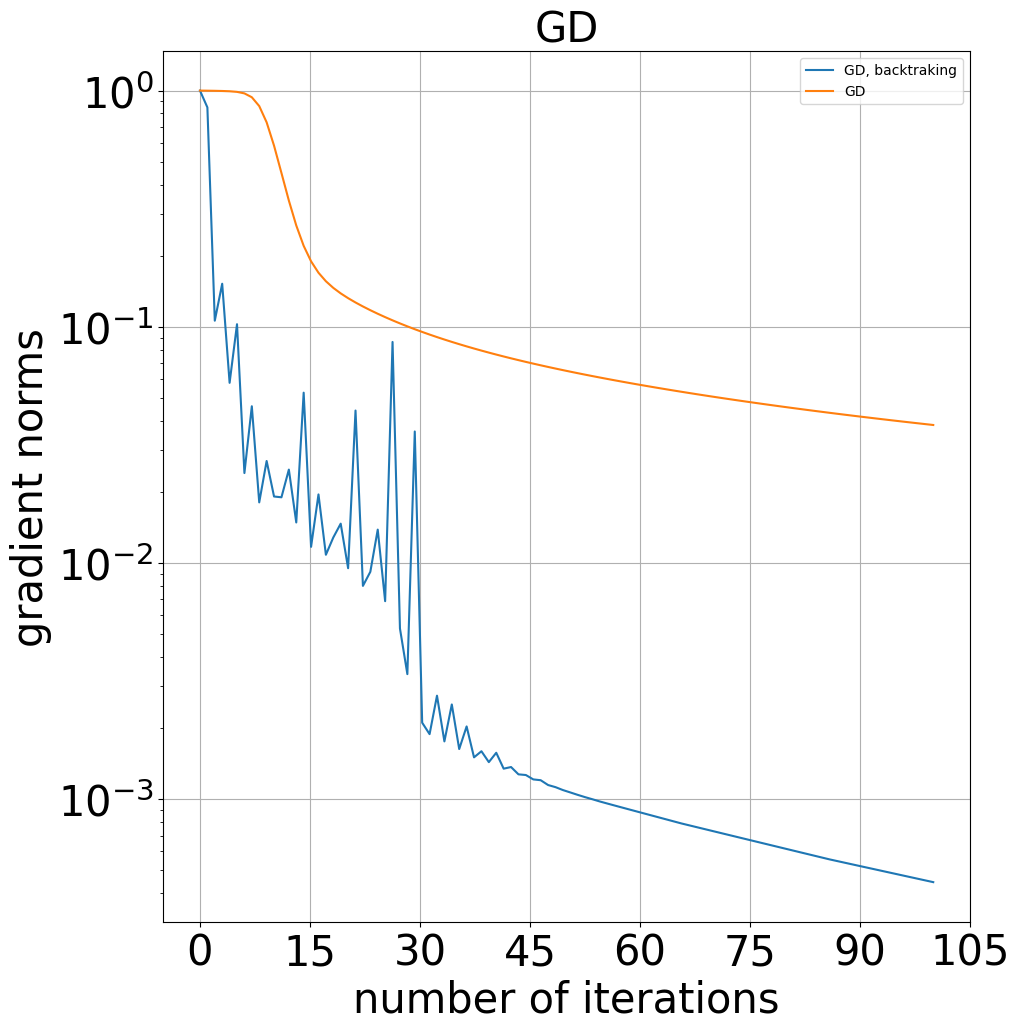

In [897]:
f,ax1 = plt.subplots(1,figsize = (10,10))

iters = 100

L = lipschitz_constan(X_train)
lmbd = L / 1000.
gamma = 1 / L
omega_0 = np.random.uniform(0, 1, size=X_train.shape[1])


omega, criterions_b, accuracy, T_b = GD(X_train, y_train, omega_0, gamma, lmbd, True, K=iters, eps=1e-5)
plt.plot(np.linspace(0, len(criterions_b), len(criterions_b)), criterions_b, label='GD, backtraking')

omega, criterions, accuracy, T = GD(X_train, y_train, omega_0, gamma, lmbd,False , K=iters, eps=1e-5)
plt.plot(np.linspace(0, len(criterions), len(criterions)), criterions, label='GD')



ax1.grid()
ax1.xaxis.set_major_locator(MaxNLocator(integer=False))
ax1.set_xlabel('number of iterations', fontsize = 30 )
ax1.set_ylabel('gradient norms', fontsize = 30 )


ax1.legend(fontsize = 10)


ax1.tick_params(axis='x', labelsize=30)
ax1.tick_params(axis='y', labelsize=30)

plt.tight_layout()

plt.title('GD', fontsize = 30)
plt.yscale('log')
plt.show()


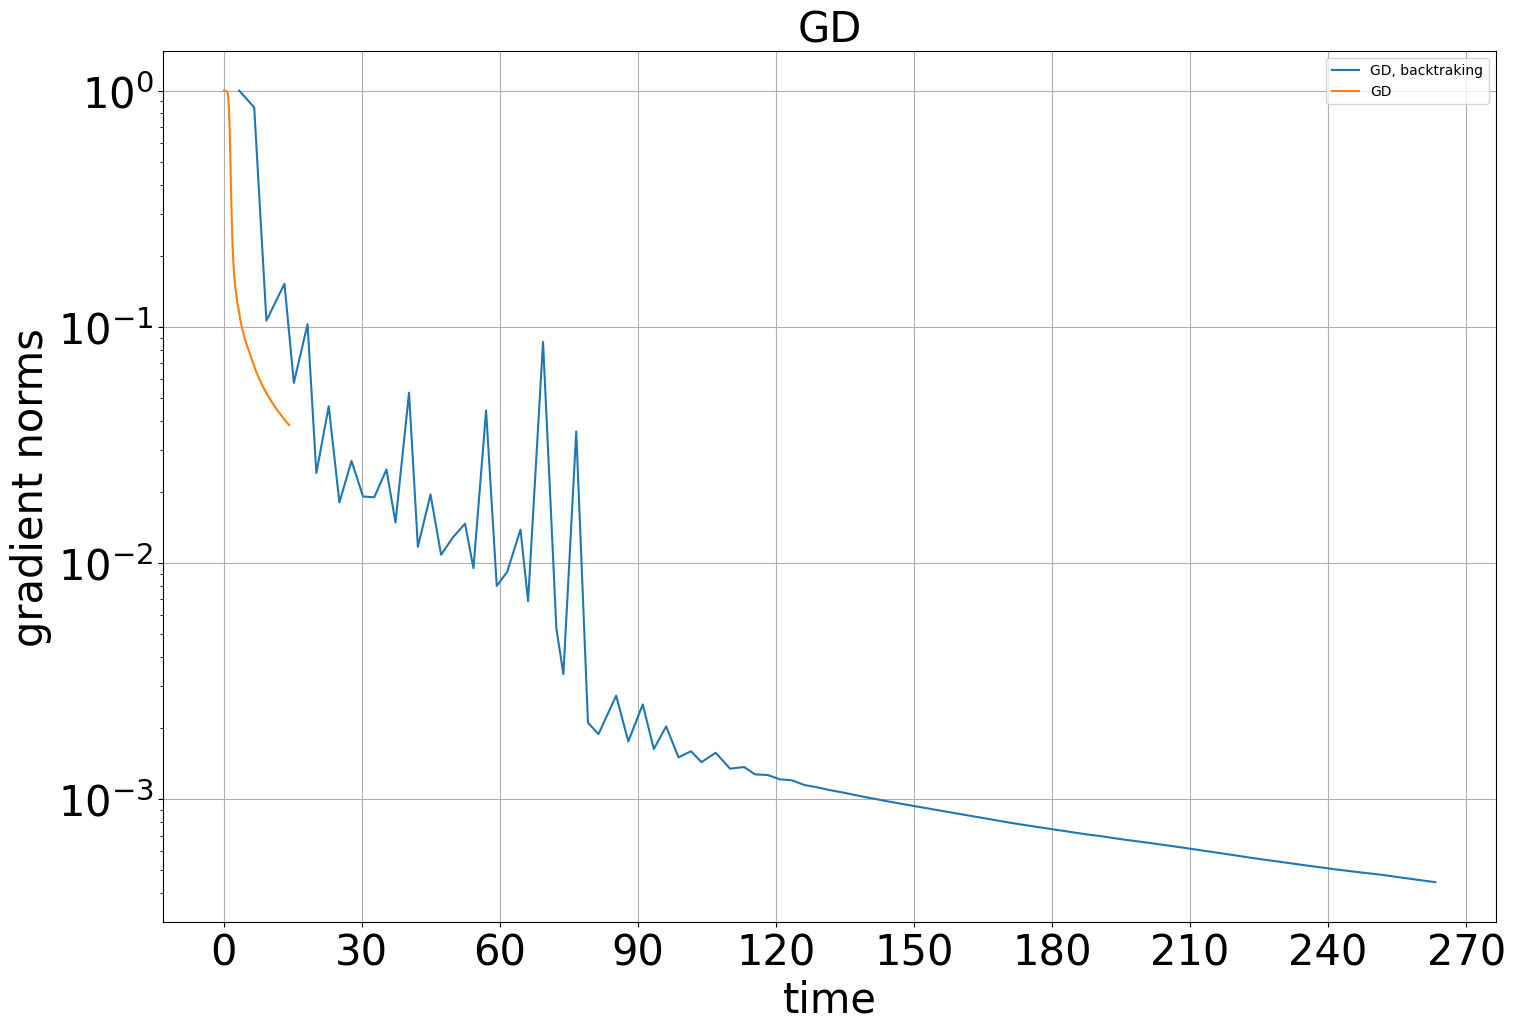

In [898]:
f,ax1 = plt.subplots(1,figsize = (15,10))


plt.plot(T_b[1:], criterions_b, label='GD, backtraking')

plt.plot(T[1:], criterions, label='GD')



ax1.grid()
ax1.xaxis.set_major_locator(MaxNLocator(integer=False))
ax1.set_xlabel('time', fontsize = 30 )
ax1.set_ylabel('gradient norms', fontsize = 30 )

#ax1.set_ylabel('$\frac{\| \nabla f(x^k) \|}{\| \nabla f(x^0) \|}$', fontsize = 30 )

ax1.legend(fontsize = 10)


ax1.tick_params(axis='x', labelsize=30)
ax1.tick_params(axis='y', labelsize=30)

plt.tight_layout()

plt.title('GD', fontsize = 30)
plt.yscale('log')
plt.show()


Compare the gradient method with backtracking and with a constant step $\frac{1}{L}$. Draw the comparison plots: 1) value of convergence criterion versus number of iterations, 2) value of convergence criterion versus time. Make a conclusion.

Backtracking procedure indeed accelerate gradient descent.But same time convergence criterion looses it's smoothness, which is understandable from physical point of view (we do bigger step). 

Second plot shows that, despite the fact that backtraking takes additional time, convergence with backtraking bacomes better then for just gradient descent with time. So, at the very begining, gradien descent showes better performanse but later  backtraking gradien descent gives less convergence criterion

__b). (40 points)__ Implement AdaGrad, RMSProp and Adam. Use the following table for convenience.

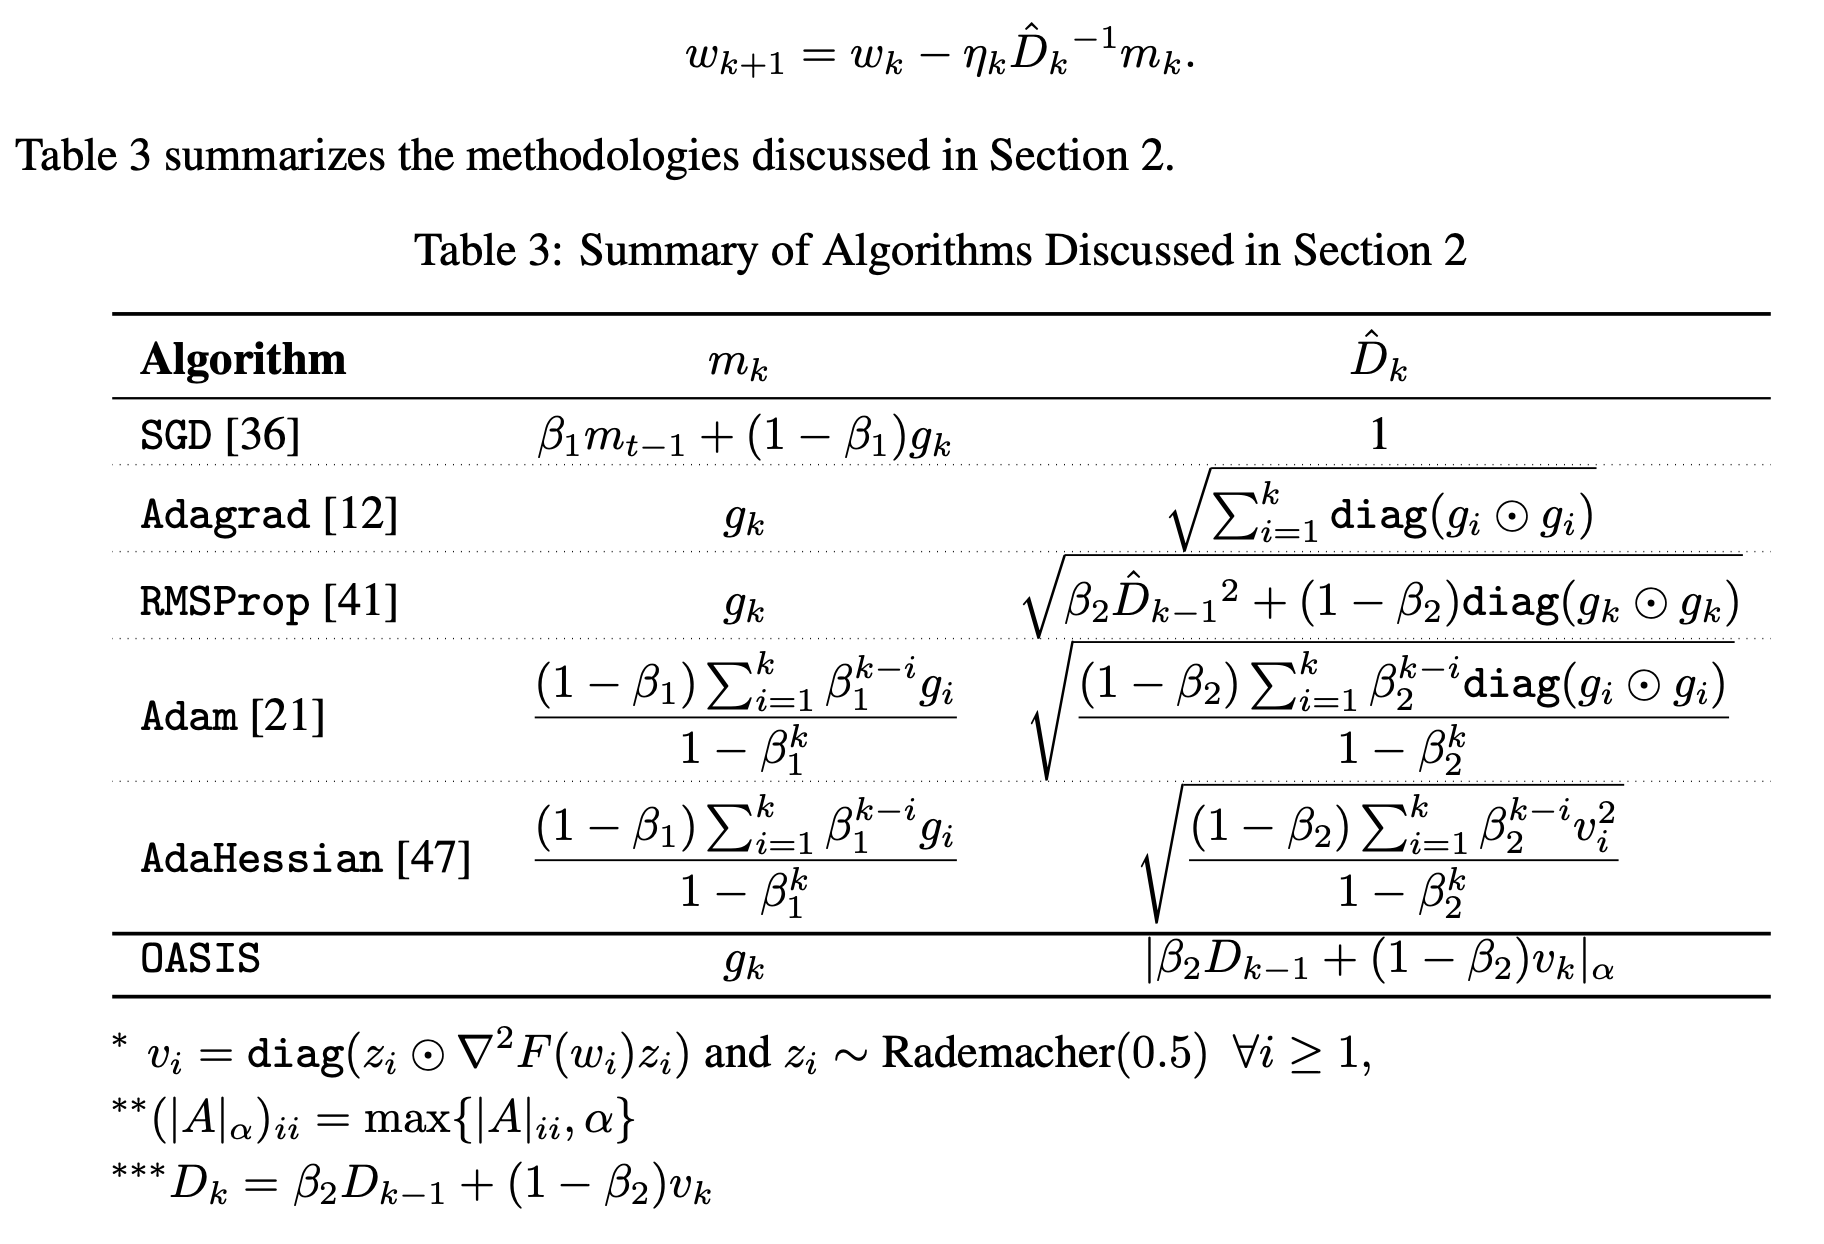


In [899]:


def ada_grad(X, y, omega_0, gamma, lmbd, backtraking, K = 10**3, eps = 1e-5):

    criterions = np.array([])
    T = np.array([0])
    accuracy = np.array([(y_test == np.where(X_test @ omega_0 >= 0, 1, -1)).mean()])

    grad_0 = analitical_grad(X, y, lmbd, omega_0)
    grad = grad_0
    D = (np.diag(grad_0 * grad_0))**(1 / 2)

    omega = omega_0
    criterion = True
    i = 0

    L_0 = 1 / gamma
    L = L_0


    while  i < K and criterion:

        start = time.time()

        if backtraking:
            L = backtracking_L(omega, L_0,  1e4, 1.1) 
            gamma = 1 / L
            

        tmp = np.linalg.norm(grad) / np.linalg.norm(grad_0)

        omega_new = omega - gamma * np.linalg.inv(D) @ grad 


        grad = analitical_grad(X, y, lmbd, omega_new)
        D = (D**2 + np.diag(grad * grad))**(1 / 2)

        omega = omega_new


        if tmp < eps:
            criterion = False

        criterions = np.append(criterions, tmp)

        end = time.time() - start

        if len(T) > 0:
            end += T[-1]

        i += 1

        accuracy = np.append(accuracy, (y_test == np.where(X_test @ omega >= 0, 1, -1)).mean())
        T = np.append(T, end)

    return omega, criterions, accuracy, T
    

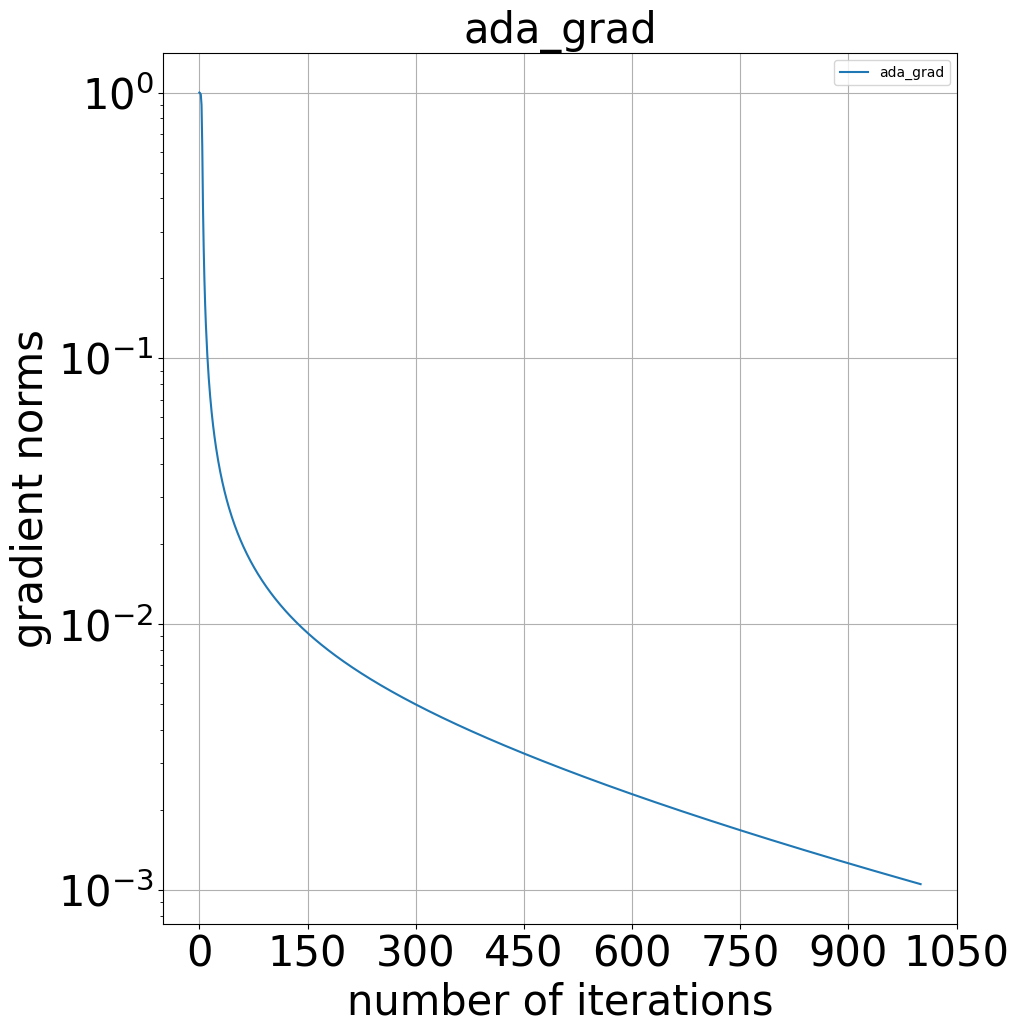

In [900]:
f,ax1 = plt.subplots(1,figsize = (10,10))

iters = 1000

L = lipschitz_constan(X_train)
lmbd = L / 1000.
gamma = 1 / L
omega_0 = np.random.uniform(0, 1, size=X_train.shape[1])


# omega, criterions_b, accuracy, T_b = ada_grad(X_train, y_train, omega_0, gamma, lmbd, True, K=iters, eps=1e-5)
# plt.plot(np.linspace(0, len(criterions_b), len(criterions_b)), criterions_b, label='ada_grad, backtraking')

omega, criterions, accuracy, T = ada_grad(X_train, y_train, omega_0, gamma, lmbd,False , K=iters, eps=1e-5)
plt.plot(np.linspace(0, len(criterions), len(criterions)), criterions, label='ada_grad')



ax1.grid()
ax1.xaxis.set_major_locator(MaxNLocator(integer=False))
ax1.set_xlabel('number of iterations', fontsize = 30 )
ax1.set_ylabel('gradient norms', fontsize = 30 )


ax1.legend(fontsize = 10)


ax1.tick_params(axis='x', labelsize=30)
ax1.tick_params(axis='y', labelsize=30)

plt.tight_layout()

plt.title('ada_grad', fontsize = 30)
plt.yscale('log')
plt.show()


In [901]:


def RMSProp(X, y, omega_0, gamma, lmbd, betta_2, backtraking, K = 10**3, eps = 1e-5):

    criterions = np.array([])
    T = np.array([0])
    accuracy = np.array([(y_test == np.where(X_test @ omega_0 >= 0, 1, -1)).mean()])

    grad_0 = analitical_grad(X, y, lmbd, omega_0)
    grad = grad_0
    D = np.sqrt(np.diag(grad_0 * grad_0))

    omega = omega_0
    criterion = True
    i = 0

    L_0 = 1 / gamma
    L = L_0


    while  i < K and criterion:

        start = time.time()

        if backtraking:
            L = backtracking_L(omega, L_0,  1e4, 1.1) 
            gamma = 1 / L
            

        tmp = np.linalg.norm(grad) / np.linalg.norm(grad_0)

        omega_new = omega - gamma * np.linalg.inv(D) @ grad 


        grad = analitical_grad(X, y, lmbd, omega_new)
        
        D = np.sqrt(betta_2 * D**2 + (1 - betta_2) * np.diag(grad * grad))


        omega = omega_new


        if tmp < eps:
            criterion = False

        criterions = np.append(criterions, tmp)

        end = time.time() - start

        if len(T) > 0:
            end += T[-1]

        i += 1

        accuracy = np.append(accuracy, (y_test == np.where(X_test @ omega >= 0, 1, -1)).mean())
        T = np.append(T, end)

    return omega, criterions, accuracy, T
    

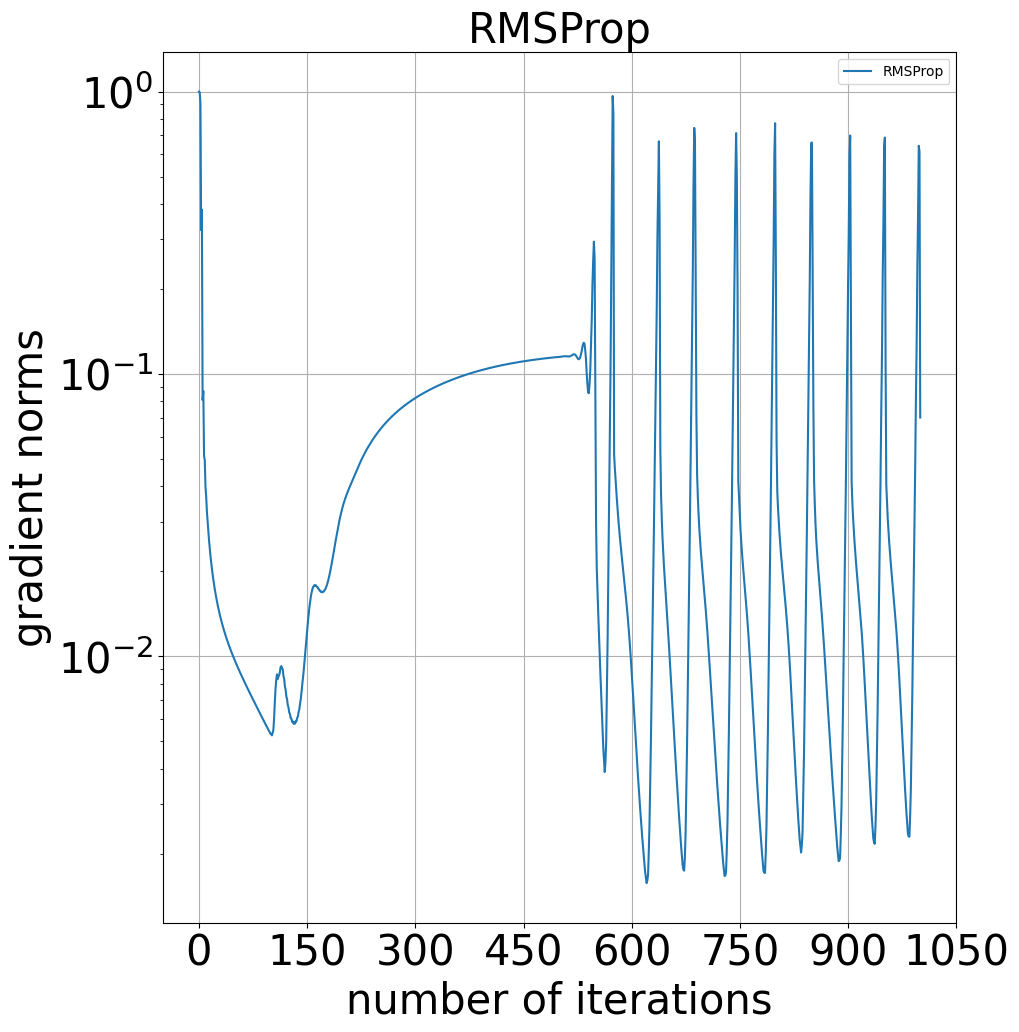

In [905]:
f,ax1 = plt.subplots(1,figsize = (10,10))

iters = 1000
betta_2 = 0.99

L = lipschitz_constan(X_train)
lmbd = L / 1000.
gamma = 1 / L
omega_0 = np.random.uniform(0, 1, size=X_train.shape[1])



omega, criterions, accuracy, T = RMSProp(X_train, y_train, omega_0, gamma, lmbd, betta_2, False , K=iters, eps=1e-5)
plt.plot(np.linspace(0, len(criterions), len(criterions)), criterions, label='RMSProp')



ax1.grid()
ax1.xaxis.set_major_locator(MaxNLocator(integer=False))
ax1.set_xlabel('number of iterations', fontsize = 30 )
ax1.set_ylabel('gradient norms', fontsize = 30 )


ax1.legend(fontsize = 10)


ax1.tick_params(axis='x', labelsize=30)
ax1.tick_params(axis='y', labelsize=30)

plt.tight_layout()

plt.title('RMSProp', fontsize = 30)
plt.yscale('log')
plt.show()



In [906]:
def m(betta_1, grad_array):

    k = grad_array.shape[0]

    tmp = 0 

    for i in range(1, k + 1):


        tmp += betta_1**(k - i) * grad_array[i - 1]

    return (1 - betta_1) / (1 - betta_1**k) * tmp

def D_k(betta_2, grad_array):

    k = grad_array.shape[0]

    tmp = 0

    for i in range(1, k + 1):


        tmp += betta_2**(k - i) * np.diag(grad_array[i - 1] * grad_array[i - 1])

    return np.sqrt((1 - betta_2) / (1 - betta_2**k) * tmp)






def Adam(X, y, omega_0, gamma, lmbd, betta_1, betta_2, backtraking, K = 10**3, eps = 1e-5):

    criterions = np.array([])
    T = np.array([0])
    accuracy = np.array([(y_test == np.where(X_test @ omega_0 >= 0, 1, -1)).mean()])


    omega = omega_0
    criterion = True
    i = 0

    L_0 = 1 / gamma
    L = L_0


    while  i < K and criterion:

        start = time.time()

        if backtraking:
            L = backtracking_L(omega, L_0,  1e4, 1.1) 
            gamma = 1 / L

        grad = analitical_grad(X, y, lmbd, omega)

        if i == 0:
            grad_array = grad
            grad_array = np.reshape(grad_array, (-1, grad_array.shape[0]))
            
        else:
            grad_array = np.vstack((grad_array, grad))
                    

        omega_new = omega - gamma * np.linalg.inv(D_k(betta_2, grad_array)) @ m(betta_1, grad_array) 

        tmp = np.linalg.norm(grad_array[-1]) / np.linalg.norm(grad_array[0])


        omega = omega_new


        if tmp < eps:
            criterion = False

        criterions = np.append(criterions, tmp)

        end = time.time() - start

        if len(T) > 0:
            end += T[-1]

        i += 1

        accuracy = np.append(accuracy, (y_test == np.where(X_test @ omega >= 0, 1, -1)).mean())
        T = np.append(T, end)

    return omega, criterions, accuracy, T
    

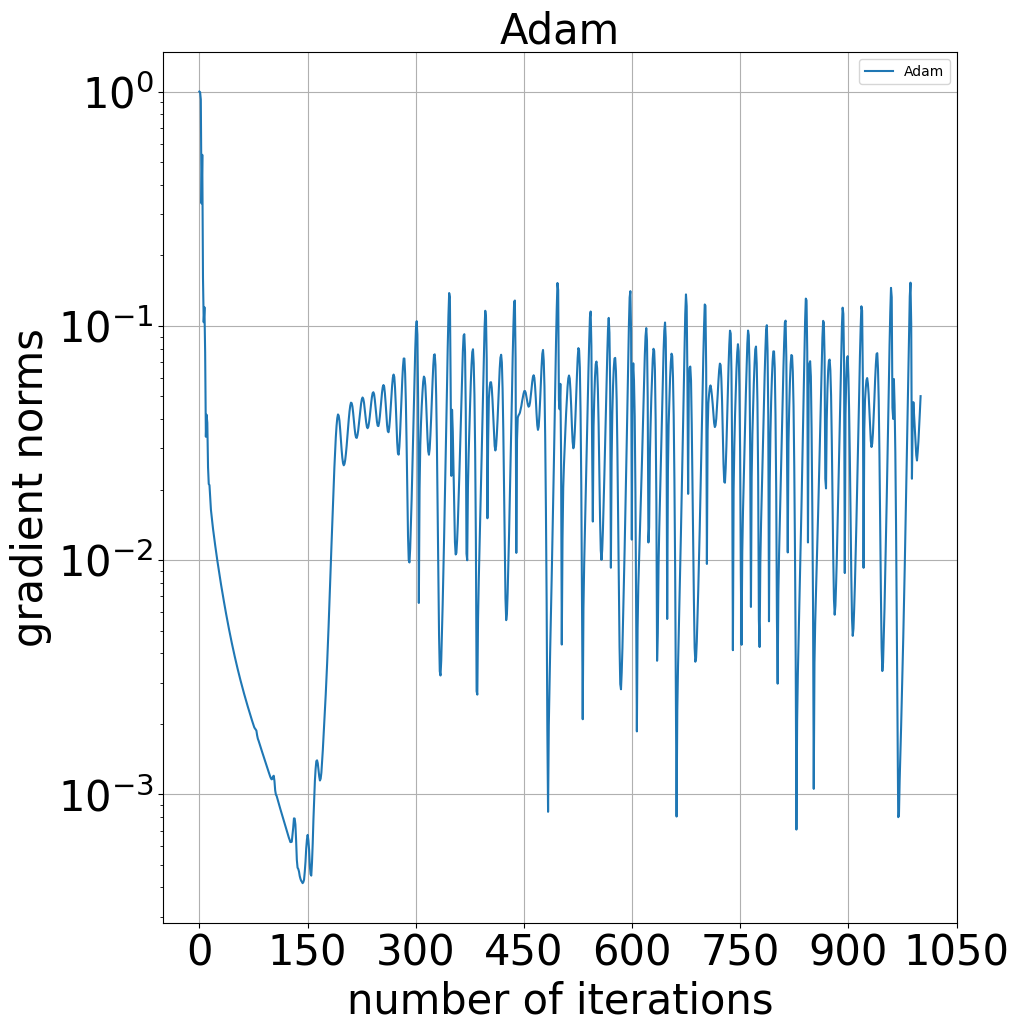

In [907]:
f,ax1 = plt.subplots(1,figsize = (10,10))

iters = 1000
betta_1 = 0.5
betta_2 = 0.99

L = lipschitz_constan(X_train)
lmbd = L / 1000.
gamma = 1 / L
omega_0 = np.random.uniform(0, 1, size=X_train.shape[1])




omega, criterions, accuracy, T = Adam(X_train, y_train, omega_0, gamma, lmbd, betta_1, betta_2, False , K=iters, eps=1e-5)
plt.plot(np.linspace(0, len(criterions), len(criterions)), criterions, label='Adam')



ax1.grid()
ax1.xaxis.set_major_locator(MaxNLocator(integer=False))
ax1.set_xlabel('number of iterations', fontsize = 30 )
ax1.set_ylabel('gradient norms', fontsize = 30 )


ax1.legend(fontsize = 10)


ax1.tick_params(axis='x', labelsize=30)
ax1.tick_params(axis='y', labelsize=30)

plt.tight_layout()

plt.title('Adam', fontsize = 30)
plt.yscale('log')
plt.show()




Fix $\beta_1 = 0$ and $\beta_2 =0.95$ (for RMSProp and Adam). Try to tune the step $\eta_k$ for each method. Explain how you determine that the step strategy is "the best" (there is no universal recipe here, just your thoughts).  Draw the comparison plot: value of convergence criterion versus number of iterations.

I don't have better idea but just to check different values of step size. 

It is hard to judge, but I would say, for RMSProp best parameter is $\eta = \frac{1.5}{L}$

For Adam $\eta = \frac{2}{L}$

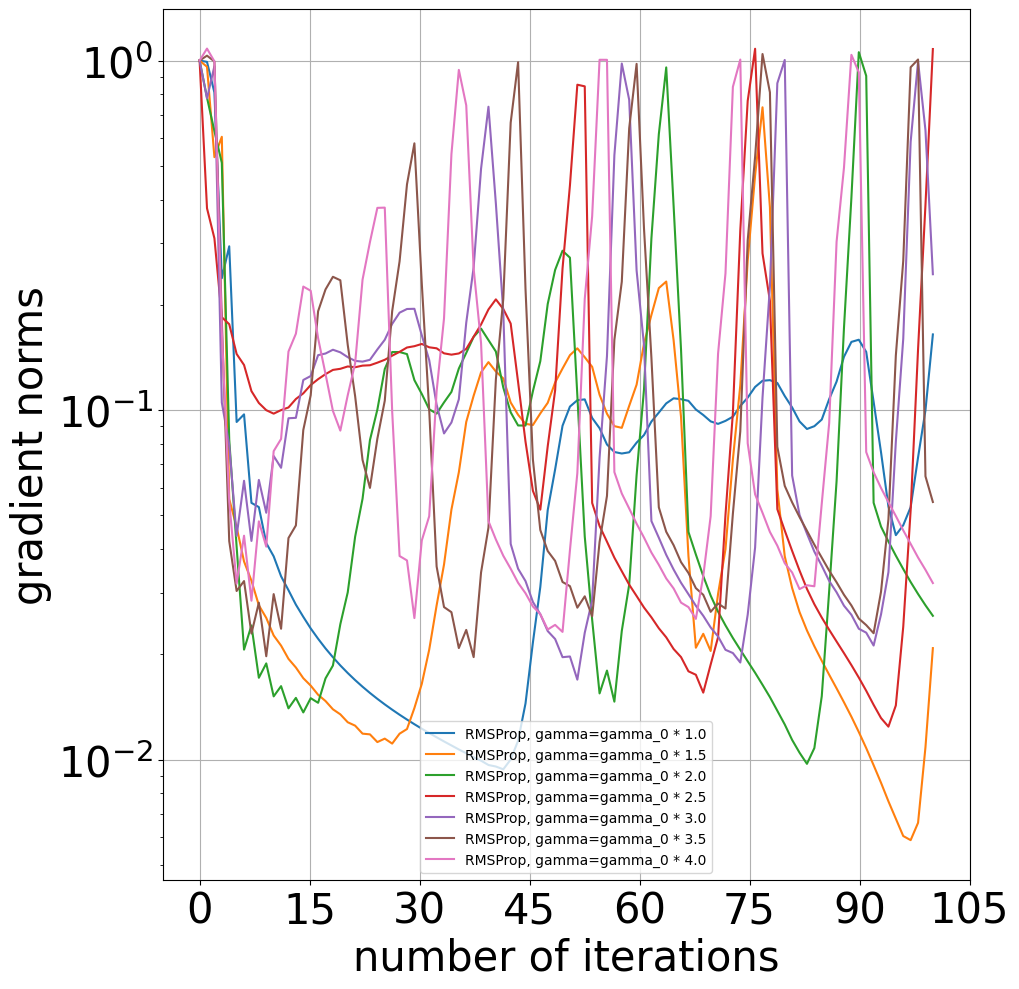

In [910]:
f,ax1 = plt.subplots(1,figsize = (10,10))

iters = 100

betta_1 = 0
betta_2 = 0.95

L = lipschitz_constan(X_train)
lmbd = L / 1000.
gamma = 1 / L
omega_0 = np.random.uniform(0, 1, size=X_train.shape[1])
l_array = np.array([1, 1.5, 2, 2.5, 3, 3.5, 4])

for l in l_array:
    omega, criterions, accuracy, T = RMSProp(X_train, y_train, omega_0, l * gamma, lmbd, betta_2, False , K=iters, eps=1e-5)
    plt.plot(np.linspace(0, len(criterions), len(criterions)), criterions, label='RMSProp, gamma=gamma_0 * '+str(l))



ax1.grid()
ax1.xaxis.set_major_locator(MaxNLocator(integer=False))
ax1.set_xlabel('number of iterations', fontsize = 30 )
ax1.set_ylabel('gradient norms', fontsize = 30 )


ax1.legend(fontsize = 10)


ax1.tick_params(axis='x', labelsize=30)
ax1.tick_params(axis='y', labelsize=30)

plt.tight_layout()

# plt.title('RMSProp', fontsize = 30)
plt.yscale('log')
plt.show()


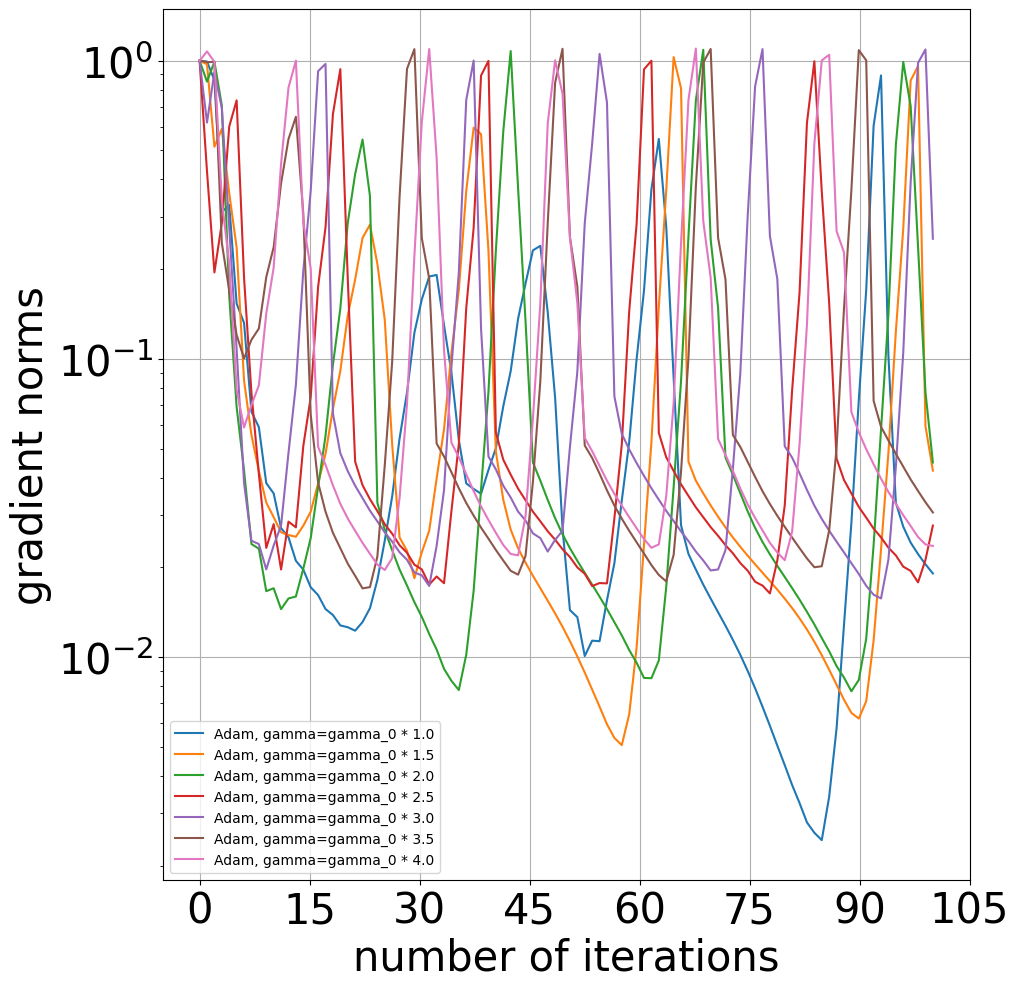

In [912]:
f,ax1 = plt.subplots(1,figsize = (10,10))

iters = 100

betta_1 = 0
betta_2 = 0.95

L = lipschitz_constan(X_train)
lmbd = L / 1000.
gamma = 1 / L
omega_0 = np.random.uniform(0, 1, size=X_train.shape[1])

l_array = np.array([1, 1.5, 2, 2.5, 3, 3.5, 4])

for l in l_array:

    omega, criterions, accuracy, T = Adam(X_train, y_train, omega_0, l * gamma, lmbd, betta_1, betta_2, False , K=iters, eps=1e-5)
    plt.plot(np.linspace(0, len(criterions), len(criterions)), criterions, label='Adam, gamma=gamma_0 * '+str(l))


ax1.grid()
ax1.xaxis.set_major_locator(MaxNLocator(integer=False))
ax1.set_xlabel('number of iterations', fontsize = 30 )
ax1.set_ylabel('gradient norms', fontsize = 30 )


ax1.legend(fontsize = 10)


ax1.tick_params(axis='x', labelsize=30)
ax1.tick_params(axis='y', labelsize=30)

plt.tight_layout()

# plt.title('RMSProp', fontsize = 30)
plt.yscale('log')
plt.show()


Fix $\beta_1 = 0$ and $\eta$ (some appropriate value based on the previous point). Vary the momentum $\beta_2 =0.5, 0.9, 0.99, 0.999$ for RMSProp and Adam. Draw the comparison plots for each method: value of convergence criterion versus number of iterations. Make a conclusion.

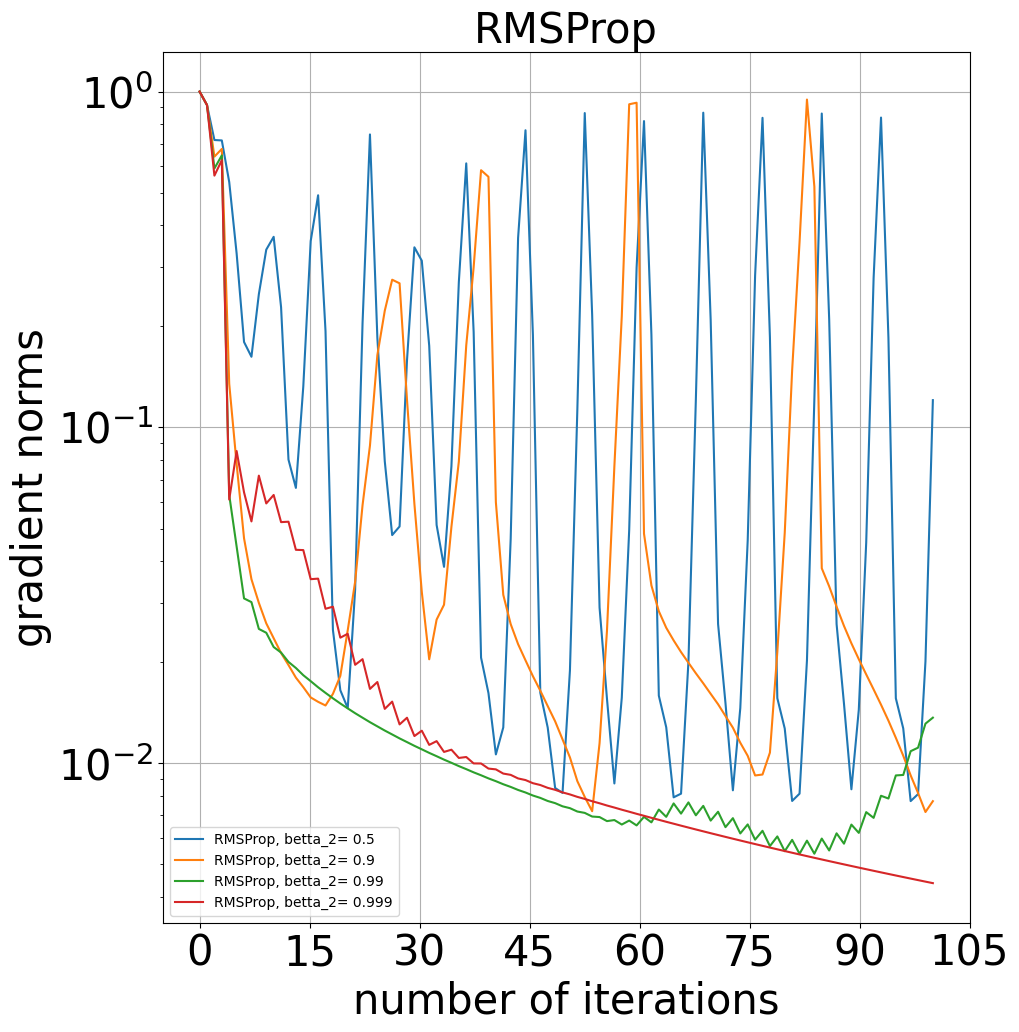

In [918]:
f,ax1 = plt.subplots(1,figsize = (10,10))

iters = 100

betta_1 = 0

L = lipschitz_constan(X_train)
lmbd = L / 1000.
gamma = 1 / L
omega_0 = np.random.uniform(0, 1, size=X_train.shape[1])
betta_2_array = np.array([0.5, 0.9, 0.99, 0.999])

for betta_2 in betta_2_array:
    omega, criterions, accuracy, T = RMSProp(X_train, y_train, omega_0, 1.5 * gamma, lmbd, betta_2, False , K=iters, eps=1e-5)
    plt.plot(np.linspace(0, len(criterions), len(criterions)), criterions, label='RMSProp, betta_2= '+str(betta_2))



ax1.grid()
ax1.xaxis.set_major_locator(MaxNLocator(integer=False))
ax1.set_xlabel('number of iterations', fontsize = 30 )
ax1.set_ylabel('gradient norms', fontsize = 30 )


ax1.legend(fontsize = 10)


ax1.tick_params(axis='x', labelsize=30)
ax1.tick_params(axis='y', labelsize=30)

plt.tight_layout()

plt.title('RMSProp', fontsize = 30)
plt.yscale('log')
plt.show()


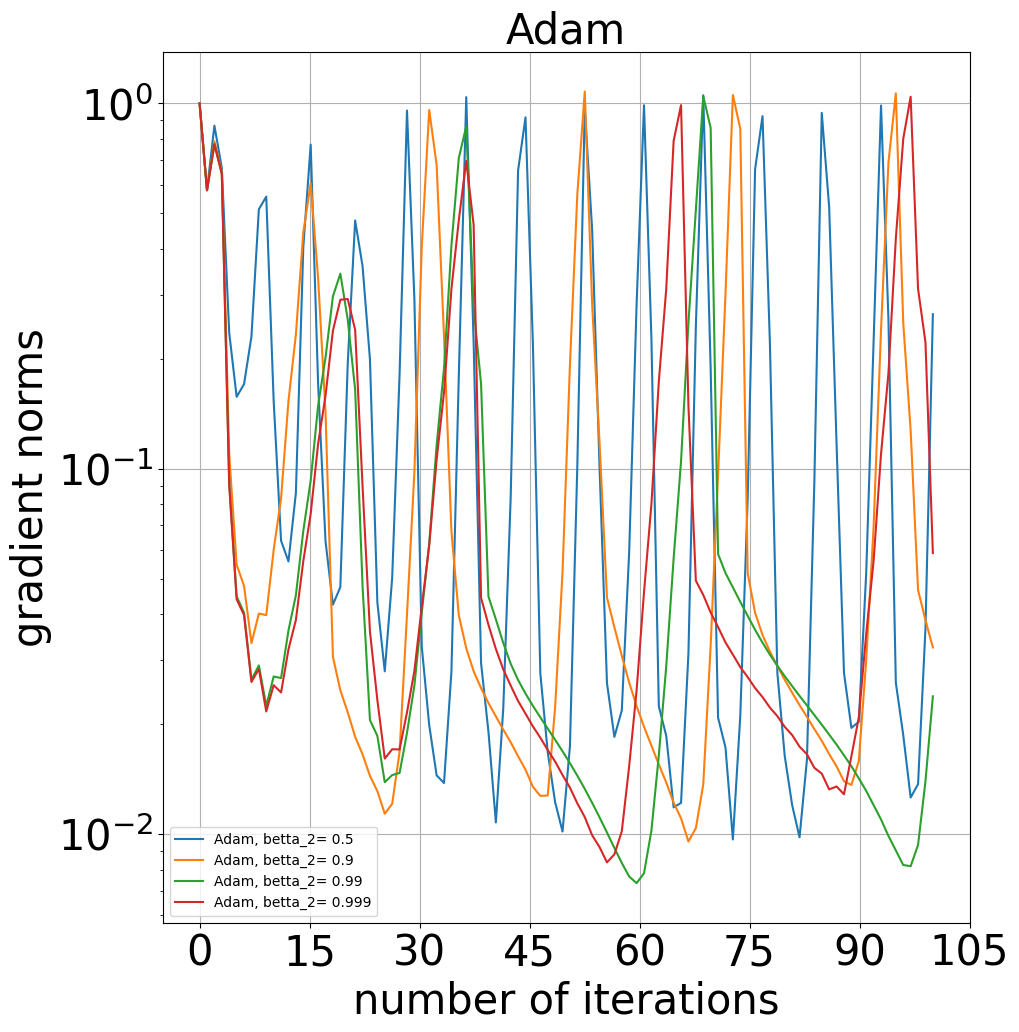

In [919]:
f,ax1 = plt.subplots(1,figsize = (10,10))

iters = 100

betta_1 = 0
betta_2 = 0.95

L = lipschitz_constan(X_train)
lmbd = L / 1000.
gamma = 1 / L
omega_0 = np.random.uniform(0, 1, size=X_train.shape[1])

betta_2_array = np.array([0.5, 0.9, 0.99, 0.999])

for betta_2 in betta_2_array:

    omega, criterions, accuracy, T = Adam(X_train, y_train, omega_0, 2 * gamma, lmbd, betta_1, betta_2, False , K=iters, eps=1e-5)
    plt.plot(np.linspace(0, len(criterions), len(criterions)), criterions, label='Adam, betta_2= '+str(betta_2))


ax1.grid()
ax1.xaxis.set_major_locator(MaxNLocator(integer=False))
ax1.set_xlabel('number of iterations', fontsize = 30 )
ax1.set_ylabel('gradient norms', fontsize = 30 )


ax1.legend(fontsize = 10)


ax1.tick_params(axis='x', labelsize=30)
ax1.tick_params(axis='y', labelsize=30)

plt.tight_layout()

plt.title('Adam', fontsize = 30)
plt.yscale('log')
plt.show()


Apparently, for RMSProp, $\beta_2 = 0.99$ gives the most stable result

For Adam, $\beta_2 = 0.99$ too

Take GD, AdaGrad, RMSProp, Adam. All methods with $\beta_1 = 0$, tuned stepsize, Adam and PRMProp with the best $\beta_2$ from the previous point. Draw the comparison plots: 1) value of convergence criterion versus number of iterations, 2) prediction accuracy versus number of iterations. Make a conclusion.

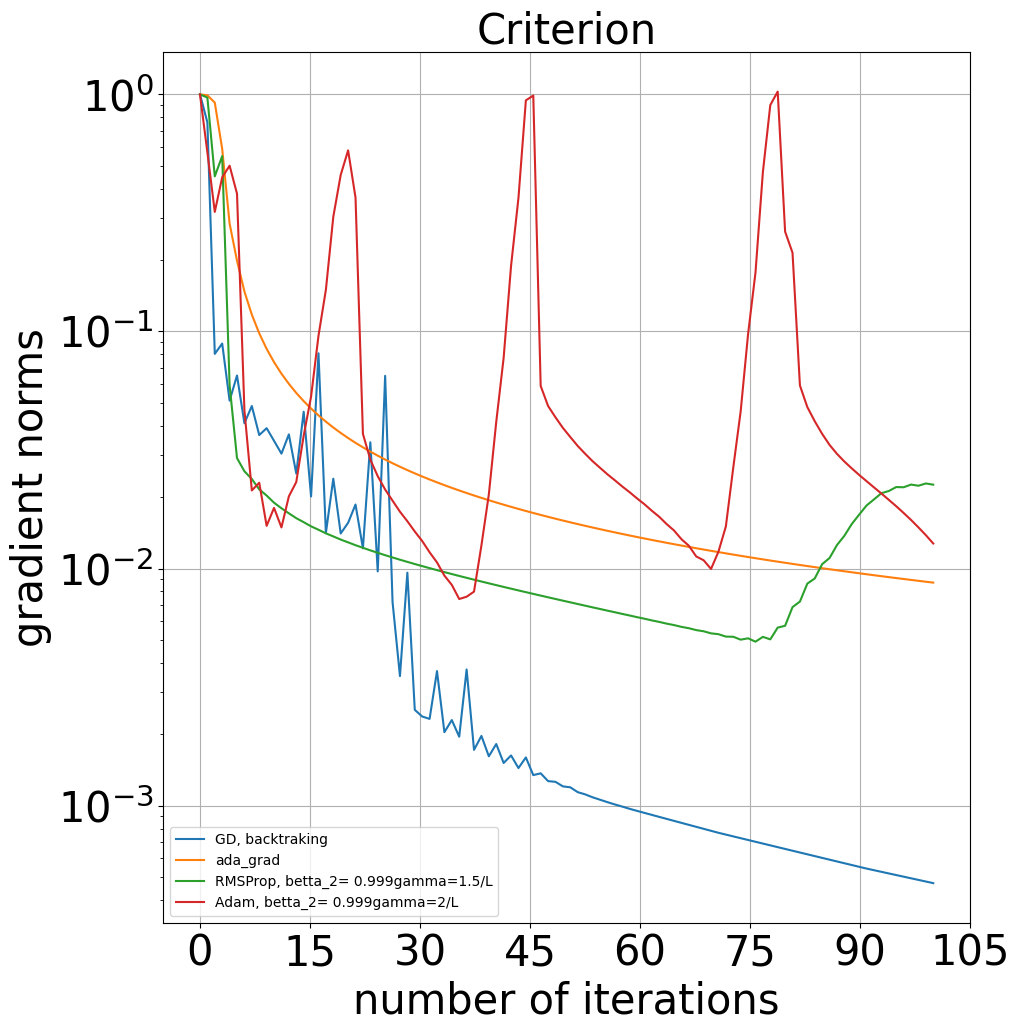

In [933]:
f,ax1 = plt.subplots(1,figsize = (10,10))

iters = 100
betta_1 = 0



L = lipschitz_constan(X_train)
lmbd = L / 1000.
gamma = 1 / L
omega_0 = np.random.uniform(0, 1, size=X_train.shape[1])
omega, criterions_b, accuracy, T_b = GD(X_train, y_train, omega_0, gamma, lmbd, True, K=iters, eps=1e-5)
ax1.plot(np.linspace(0, len(criterions_b), len(criterions_b)), criterions_b, label='GD, backtraking')



lmbd = L / 1000.
gamma = 1 / L
omega, criterions, accuracy, T = ada_grad(X_train, y_train, omega_0, gamma, lmbd,False , K=iters, eps=1e-5)
ax1.plot(np.linspace(0, len(criterions), len(criterions)), criterions, label='ada_grad')


lmbd = L / 1000.
gamma = 1 / L
omega_0 = np.random.uniform(0, 1, size=X_train.shape[1])
omega, criterions, accuracy, T = RMSProp(X_train, y_train, omega_0, 1.5 * gamma, lmbd, 0.99, False , K=iters, eps=1e-5)
ax1.plot(np.linspace(0, len(criterions), len(criterions)), criterions, label='RMSProp, betta_2= '+str(betta_2)+'gamma='+str(1.5)+'/L')



lmbd = L / 1000.
gamma = 1 / L
omega_0 = np.random.uniform(0, 1, size=X_train.shape[1])
omega, criterions, accuracy, T = Adam(X_train, y_train, omega_0, 2 * gamma, lmbd, betta_1, 0.99, False , K=iters, eps=1e-5)
ax1.plot(np.linspace(0, len(criterions), len(criterions)), criterions, label='Adam, betta_2= '+str(betta_2)+'gamma='+str(2)+'/L')


ax1.grid()
ax1.xaxis.set_major_locator(MaxNLocator(integer=False))
ax1.set_xlabel('number of iterations', fontsize = 30 )
ax1.set_ylabel('gradient norms', fontsize = 30 )


ax1.legend(fontsize = 10)


ax1.tick_params(axis='x', labelsize=30)
ax1.tick_params(axis='y', labelsize=30)

plt.tight_layout()

plt.title('Criterion', fontsize = 30)
plt.yscale('log')
plt.show()


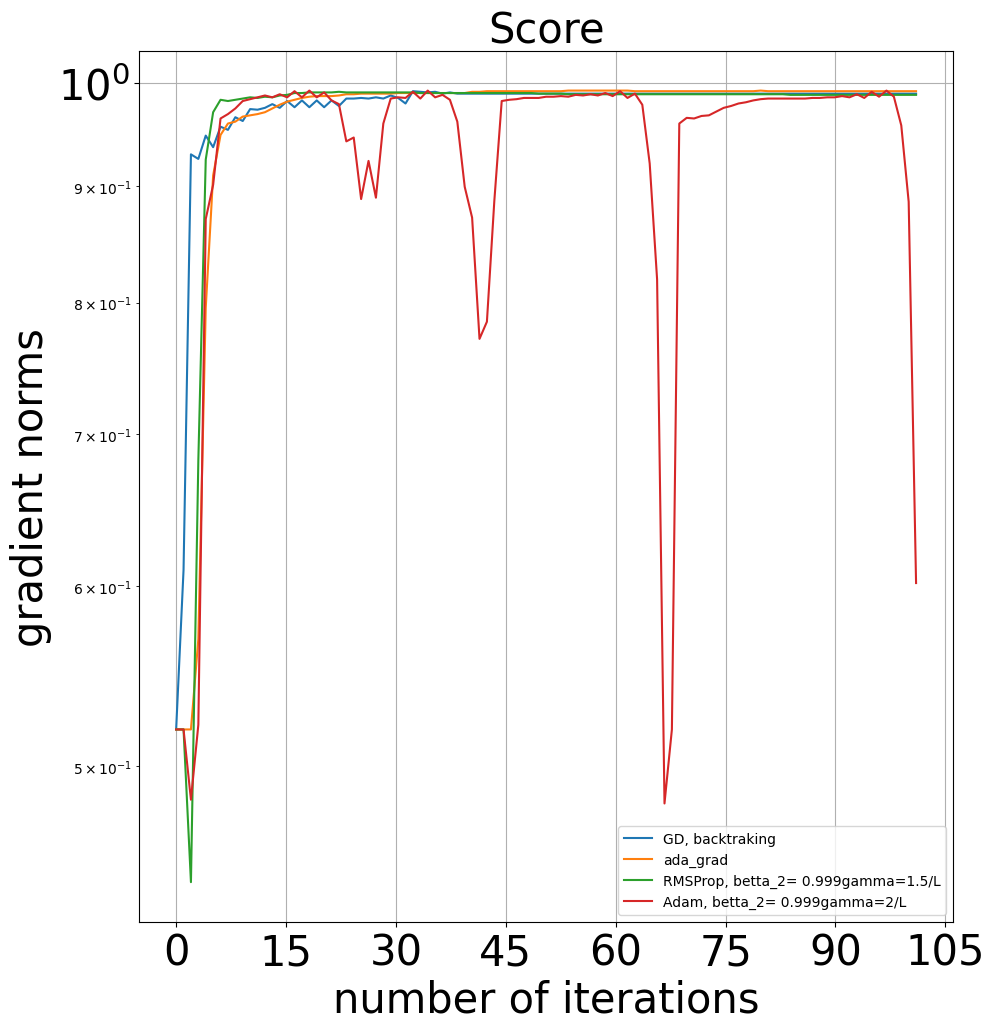

In [934]:
f,ax1 = plt.subplots(1,figsize = (10,10))

iters = 100
betta_1 = 0



L = lipschitz_constan(X_train)
lmbd = L / 1000.
gamma = 1 / L
omega_0 = np.random.uniform(0, 1, size=X_train.shape[1])
omega, criterions_b, accuracy, T_b = GD(X_train, y_train, omega_0, gamma, lmbd, True, K=iters, eps=1e-5)
ax1.plot(np.linspace(0, len(accuracy), len(accuracy)), accuracy, label='GD, backtraking')



lmbd = L / 1000.
gamma = 1 / L
omega, criterions, accuracy, T = ada_grad(X_train, y_train, omega_0, gamma, lmbd,False , K=iters, eps=1e-5)
ax1.plot(np.linspace(0, len(accuracy), len(accuracy)), accuracy, label='ada_grad')


lmbd = L / 1000.
gamma = 1 / L
omega_0 = np.random.uniform(0, 1, size=X_train.shape[1])
omega, criterions, accuracy, T = RMSProp(X_train, y_train, omega_0, 1.5 * gamma, lmbd, 0.99, False , K=iters, eps=1e-5)
ax1.plot(np.linspace(0, len(accuracy), len(accuracy)), accuracy, label='RMSProp, betta_2= '+str(betta_2)+'gamma='+str(1.5)+'/L')



lmbd = L / 1000.
gamma = 1 / L
omega_0 = np.random.uniform(0, 1, size=X_train.shape[1])
omega, criterions, accuracy, T = Adam(X_train, y_train, omega_0, 2 * gamma, lmbd, betta_1, 0.99, False , K=iters, eps=1e-5)
ax1.plot(np.linspace(0, len(accuracy), len(accuracy)), accuracy, label='Adam, betta_2= '+str(betta_2)+'gamma='+str(2)+'/L')




ax1.grid()
ax1.xaxis.set_major_locator(MaxNLocator(integer=False))
ax1.set_xlabel('number of iterations', fontsize = 30 )
ax1.set_ylabel('gradient norms', fontsize = 30 )


ax1.legend(fontsize = 10)


ax1.tick_params(axis='x', labelsize=30)
ax1.tick_params(axis='y', labelsize=30)

plt.tight_layout()

plt.title('Score', fontsize = 30)
plt.yscale('log')
plt.show()



I can conclude that GD with backtraking gives better converges then others methods

And all methods gives similar accuresy except Adam

### Part 2. Coordinate methods

It turns out methods that work with gradient coordinates instead of full gradients often occur in the non-distributed setup as well. The simplest version of the coordinate descent method looks as follows:
$$
x^{k+1} = x^k - \gamma d \cdot e_{i_k} [\nabla f(x^k)]_{i_k},
$$
where we sample uniformly and independently $i_k \in \{1, \ldots d\}$ and $e_i$ is the $i$th basis vector. Such methods may be especially important in the blac-box/zero-order setting when we cannot actually compute the directional derivative but can only approximate it through finite differences:

\begin{equation}
\tag{0}
[\nabla f(x^k)]_{i_k} \approx \frac{f(x^k + \tau e_{i_k}) - f(x^k - \tau e_{i_k})}{2 \tau} \cdot e_{i_k}.
\end{equation}

In this part of the assignment, we will further always assume that we can only consider the directional derivative in this way. But for brevity of notation, we will still use $[\nabla f(x)]_{i}$.

We simulate the setup where we cannot compute derivatives but only finite differences (see (0)) on our already standard logistic regression problem on dataset mushrooms.

__Problem 0. (10 points)__ Realize a finite difference of the form (0). Varying $\tau$ and knowing (only for this point of the assignment it is known) the real directional derivative, find the best option for $\tau$: estimate how much the norm of the difference between the real directional derivative and its approximation changes with the change of $\tau$. Whether this dependence is monotone. If not, why not? Using this dependence, fix some $\tau$ and do not change it further in this part of the assignment about coordinate methods.

In [1014]:
def finite_difference(X, y, lmbd, omega, k, tau):

    e_k = np.zeros(X.shape[1])
    e_k[int(k - 1)] = 1

    delta = (function(X, y, lmbd, omega + e_k * tau) -function(X, y, lmbd, omega - e_k * tau)) / (2 * tau) * e_k

    return delta



In [1010]:
L = lipschitz_constan(X_train)
lmbd = L / 1000.
t = 50
omega_0 = np.random.uniform(0, 1, size=X_train.shape[1])

e_k = np.zeros(X_train.shape[1])
e_k[t - 1] = 1

mag_arr = np.array([])

max_k = 9

for k in range(0, max_k + 1):

    mag_arr = np.append(mag_arr, np.linalg.norm(finite_difference(X_train, y_train, lmbd, omega, t, 10**(-k)) - analitical_grad(X_train, y_train, lmbd, omega) * e_k))




No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


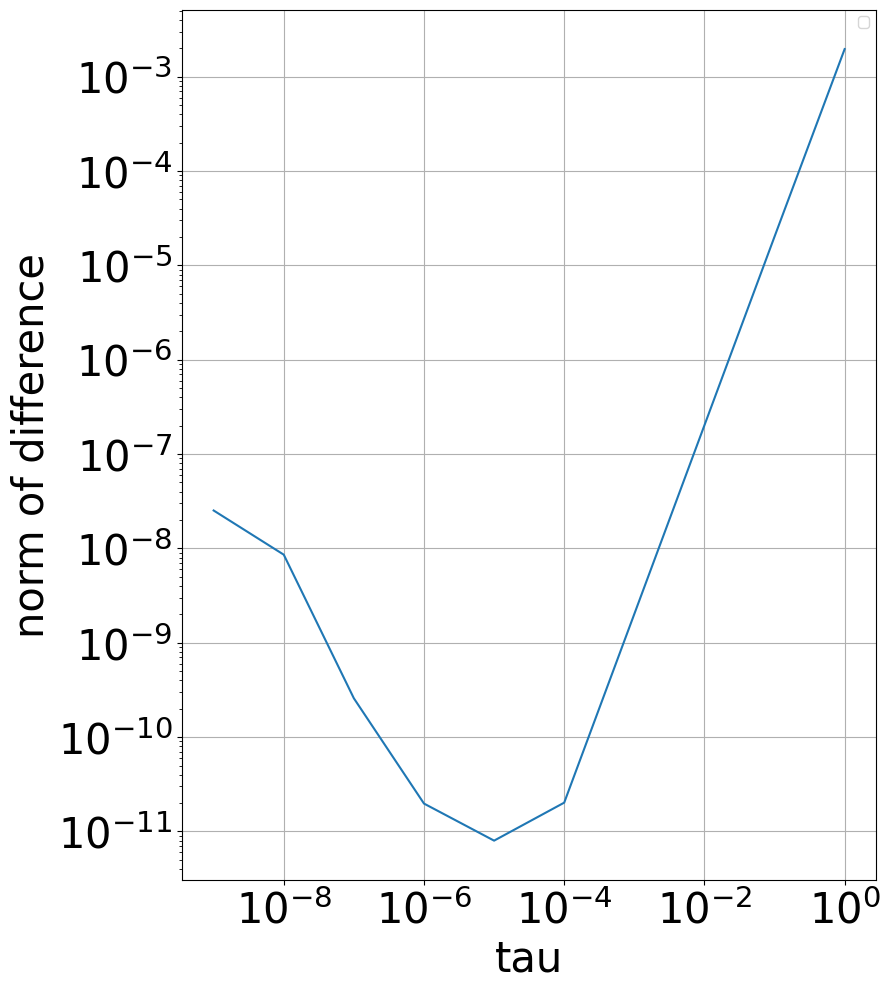

In [1011]:
f,ax1 = plt.subplots(1,figsize = (10,10))

x_ax = [10**(-k) for k in range(0, max_k + 1)]


ax1.plot(x_ax, mag_arr)




ax1.grid()
ax1.xaxis.set_major_locator(MaxNLocator(integer=False))
ax1.set_xlabel('tau', fontsize = 30 )
ax1.set_ylabel('norm of difference', fontsize = 30 )


ax1.legend(fontsize = 10)


ax1.tick_params(axis='x', labelsize=30)
ax1.tick_params(axis='y', labelsize=30)

plt.tight_layout()

plt.yscale("log") 
plt.xscale("log") 
plt.show()



Optimal $\tau$ depends on direction but I would say on average $\tau_{optimal} = 10^{-5}$

Dependense is not monotone because of machine accuracy. Ideally, norn difference should decrease but at some point this difference reach machine accuracy and futher grows

__Problem 1. (20 points)__ 

Implement the coordinate descent. Try to tune the step for this method. Explain how you determine the tuning strategy. Draw the comparison plot for the cordinate descent with tuned step and step $\frac{1}{dL}$: value of convergence criterion versus number of iterations. Make a conclusion.

In [1086]:
def backtracking_L_coordinate(omega_0, L_0, ration, rho, k, tau):

    d = omega_0.shape[0]
    L = L_0 / ration 
    lmbd = L_0 / 1000.
    fx = function(X, y, lmbd, omega_0)
    gradx = finite_difference(X, y, lmbd, omega_0, k, tau)
    h = gradx


    while L < L_0 :
        
        omega_new = omega_0 - 1 / L * h

        if function(X, y, lmbd, omega_new) <= fx - 1 / L * gradx @ h + 1 / (2 * L) * h @ h:
            break
        else:
            L = L * rho
        
    if L < L_0:
            
        return L
    
    else:

        return L_0 
    



def coordinate_GD(X, y, omega_0, gamma, lmbd, tau, backtraking, K=1e3, eps=1e-5):

    criterions = np.array([])
    T = np.array([0])
    accuracy = np.array([(y_test == np.where(X_test @ omega_0 >= 0, 1, -1)).mean()])

    grad_0 = analitical_grad(X, y, lmbd, omega_0)
    omega = omega_0
    criterion = True
    i = 0
    d = omega_0.shape[0]

    L_0 = 1 / gamma 


    while  i < K and criterion:


        start = time.time()
        
        k = np.random.uniform(1, 112, 1)[0]


        if backtraking:
            L = backtracking_L_coordinate(omega, L_0,  1e4, 1.1, k, tau) 
            gamma = 1 / L 

            # print(L)

            
        grad = finite_difference(X, y, lmbd, omega, k, tau)


        omega_new = omega -  d * gamma * grad 

        tmp = np.linalg.norm(analitical_grad(X, y, lmbd, omega)) / np.linalg.norm(grad_0)

        if tmp < eps:
            criterion = False

        criterions = np.append(criterions, tmp)

        end = time.time() - start

        if len(T) > 0:
            end += T[-1]

        i += 1

        omega = omega_new

        accuracy = np.append(accuracy, (y_test == np.where(X_test @ omega >= 0, 1, -1)).mean())
        T = np.append(T, end)

    return omega, criterions, accuracy, T


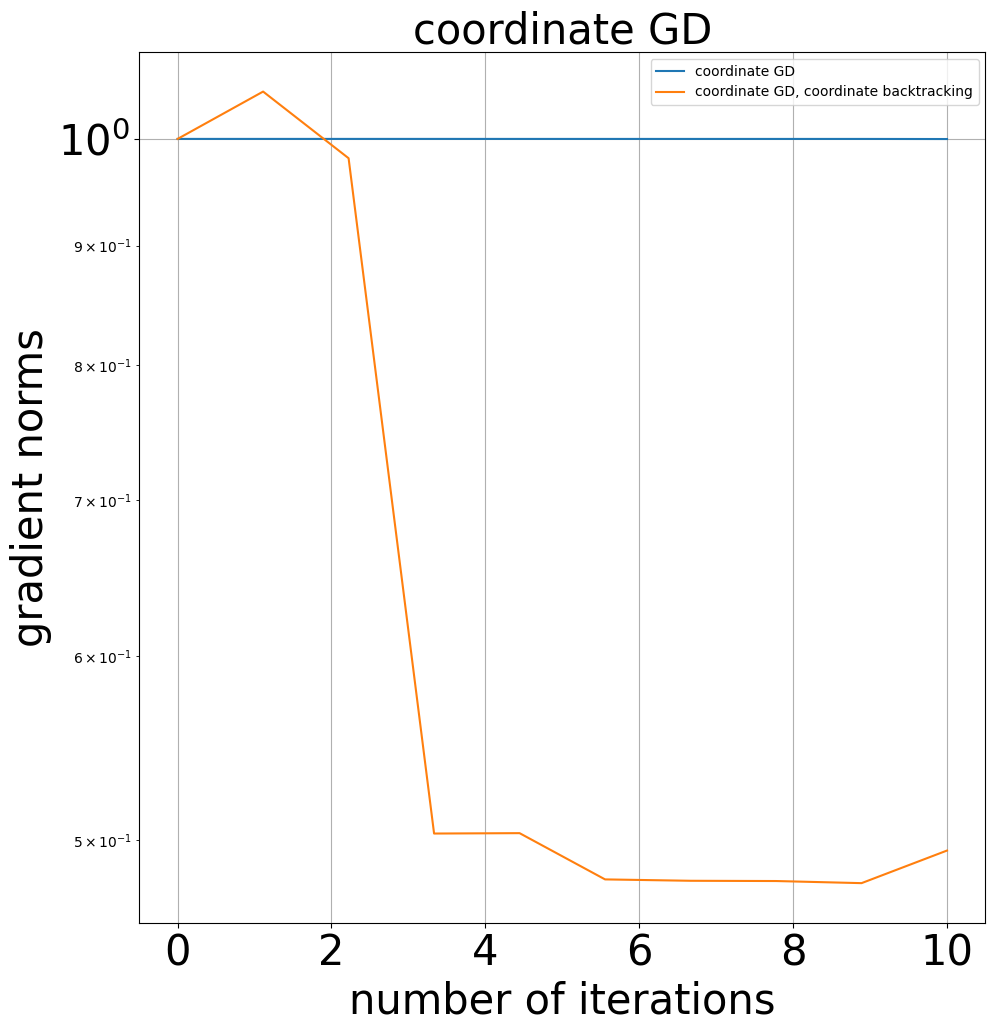

In [1081]:
f,ax1 = plt.subplots(1,figsize = (10,10))
tau = 1e-5
iters = 10

d = omega_0.shape[0]

L = lipschitz_constan(X_train)
lmbd = L / 1000.
gamma = 1 / L / d
omega_0 = np.random.uniform(0, 1, size=X_train.shape[1])



omega, criterions, accuracy, T = coordinate_GD(X, y, omega_0, gamma, lmbd, tau, False, K = iters, eps = 1e-5)

plt.plot(np.linspace(0, len(criterions), len(criterions)), criterions, label='coordinate GD')


omega, criterions, accuracy, T = coordinate_GD(X, y, omega_0, gamma, lmbd, tau, True, K = iters, eps = 1e-5)

plt.plot(np.linspace(0, len(criterions), len(criterions)), criterions, label='coordinate GD, coordinate backtracking')



ax1.grid()
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
ax1.set_xlabel('number of iterations', fontsize = 30 )
ax1.set_ylabel('gradient norms', fontsize = 30 )


ax1.legend(fontsize = 10)


ax1.tick_params(axis='x', labelsize=30)
ax1.tick_params(axis='y', labelsize=30)

plt.tight_layout()

# plt.title('coordinate GD', fontsize = 30)
plt.yscale('log')
plt.show()


I tune step size using coordinate backtraking, the only difference with standart one is that instead of full gradient I put directional derivitev

__Problem 2. (20 + 40 points)__ Let us improve the idea of the coordinate method using the idea of SAGA.

__a). (bonus 40 points)__ Consider the following algorithm:

__Input:__ starting point $x^0$, step $\gamma$, $h^0 = 0$

__for__ $k = 0, \ldots K$

 Sample uniformly and independently $i_k \in \{1, \ldots d\}$
 
 $h^{k+1} = h^k + e_{i_k} ( [\nabla f(x^k)]_{i_k} - [h^k]_{i_k})$
 
 $g^{k} = h^k + d \cdot e_{i_k} ( [\nabla f(x^k)]_{i_k} - [h^k]_{i_k})$
 
 $x^{k+1} = x^k - \gamma g^k$
 
__endfor__

In this part it is suggested to prove the convergence of the method by following the plan.

We start with the familiar relationship:

\begin{equation}
\mathbb{E}\left[\| x^{k+1} - x^*\|^2_2 \mid x^k \right] = \| x^k - x^*\|^2_2 - 2 \gamma \langle \mathbb{E}[g^k \mid x^k], x^k - x^*\rangle + \mathbb{E}\left[ \| g^k - \nabla f(x^*) \|^2_2\mid x^k\right]
\end{equation}

Prove that $g^k$ is an unbiased estimate of $\nabla f(x^k)$, i.e. $\mathbb{E}[g^k \mid x^k] = \nabla f(x^k)$:

First of all we will consider expectation coordinatewise:

$$E[g^k|x^k]_i = \frac{1}{d}[h^k + de_i( [\nabla f(x^k)]_i - [h^k]_i)]_i + \frac{d - 1}{d}[h^k]_i = \frac{1 - d}{d} [h^k]_i + [ \nabla f(x^k)]_i + \frac{d - 1}{d}[h^k]_i = [\nabla f(x^k)]_i$$

Then, for gradient we get following expression:

$$E[g^k|x^k] = \nabla f(x^k)$$

Now we have

\begin{equation}
\tag{1}
\mathbb{E}\left[\| x^{k+1} - x^*\|^2_2 \mid x^k \right] = \| x^k - x^*\|^2_2 - 2 \gamma \langle \nabla f(x^k), x^k - x^*\rangle + \mathbb{E}\left[ \| g^k - \nabla f(x^*) \|^2_2\mid x^k\right]
\end{equation}

We need to estimate $\mathbb{E}\left[ \| g^k - \nabla f(x^*) \|^2_2\mid x^k\right]$. Here we can use SAGA-like handling: "smart" zero, property of variance, Cauchy-Schwartz inequality, and $L$-smoothness+convexity of $f$. If we have done everything correctly, we should get an estimate of the form:
\begin{equation}
\tag{2}
\mathbb{E}\left[ \| g^k - \nabla f(x^*) \|^2_2\mid x^k\right] \leq A \cdot L (f(x^k) - f(x^*)) + B \cdot \| h^k - \nabla f(x^*)\|^2_2,
\end{equation}
where $A$, $B$ are some constants (need to find).

Next, we estimate $\mathbb{E}\left[ \| h^{k+1} - \nabla f(x^*) \|^2_2\mid x^k\right]$. Here it is enough to use the update rule for $h^{k+1}$ and $L$-smoothness+convexity of $f$. If we have done everything correctly, we should get an estimate of the form:
\begin{equation}
\tag{3}
\mathbb{E}\left[ \| h^{k+1} - \nabla f(x^*) \|^2_2\mid x^k\right] \leq (1 - \rho)\| h^{k} - \nabla f(x^*) \|^2_2 + C \cdot L (f(x^k) - f(x^*)),
\end{equation}
where $\rho$, $C$ are some constants (need to find).

In [ ]:
#your solution (Markdown)

It remains to combine (1), (2), (3), as in the proof of SAGA and use $\mathbb{E}\left[\| x^{k} - x^*\|^2_2 + M \| h^k - \nabla f(x^*) \|^2_2\right]$ as convergence criterion, where $M$ needs to be picked up.

In [ ]:
#your solution (Markdown)

Formulate the сonvergence theorem:

In [ ]:
#your solution (Markdown)

__b). (20 points)__ Implement this new method. Take a step is equal to $\frac{1}{dL}$. 
Draw the comparison plot with the simple coordinate descent (step $\frac{1}{dL}$): value of convergence criterion versus number of iterations. Make a conclusion.

In [1090]:


def SAGA(X, y, omega_0, gamma, lmbd, tau, backtraking, K=1e3, eps=1e-5):

    criterions = np.array([])
    T = np.array([0])
    accuracy = np.array([(y_test == np.where(X_test @ omega_0 >= 0, 1, -1)).mean()])

    grad_0 = analitical_grad(X, y, lmbd, omega_0)
    omega = omega_0
    criterion = True
    i = 0
    d = omega_0.shape[0]

    L_0 = 1 / gamma 

    h = 0


    while  i < K and criterion:


        start = time.time()
        
        k = np.random.uniform(1, 112, 1)[0]

        e_k = np.zeros(X.shape[1])
        e_k[int(k - 1)] = 1


        if backtraking:
            L = backtracking_L_coordinate(omega, L_0,  1e4, 1.1, k, tau) 
            gamma = 1 / L

            
        grad = finite_difference(X, y, lmbd, omega, k, tau)

        h_new = h + e_k * (grad - h * e_k)

        g = h + d * e_k * (grad - h * e_k)

        omega_new = omega - gamma * g
        
        h = h_new
        
        tmp = np.linalg.norm(analitical_grad(X, y, lmbd, omega_new)) / np.linalg.norm(grad_0)

        if tmp < eps:
            criterion = False

        criterions = np.append(criterions, tmp)

        end = time.time() - start

        if len(T) > 0:
            end += T[-1]

        i += 1

        omega = omega_new

        accuracy = np.append(accuracy, (y_test == np.where(X_test @ omega >= 0, 1, -1)).mean())
        T = np.append(T, end)

    return omega, criterions, accuracy, T


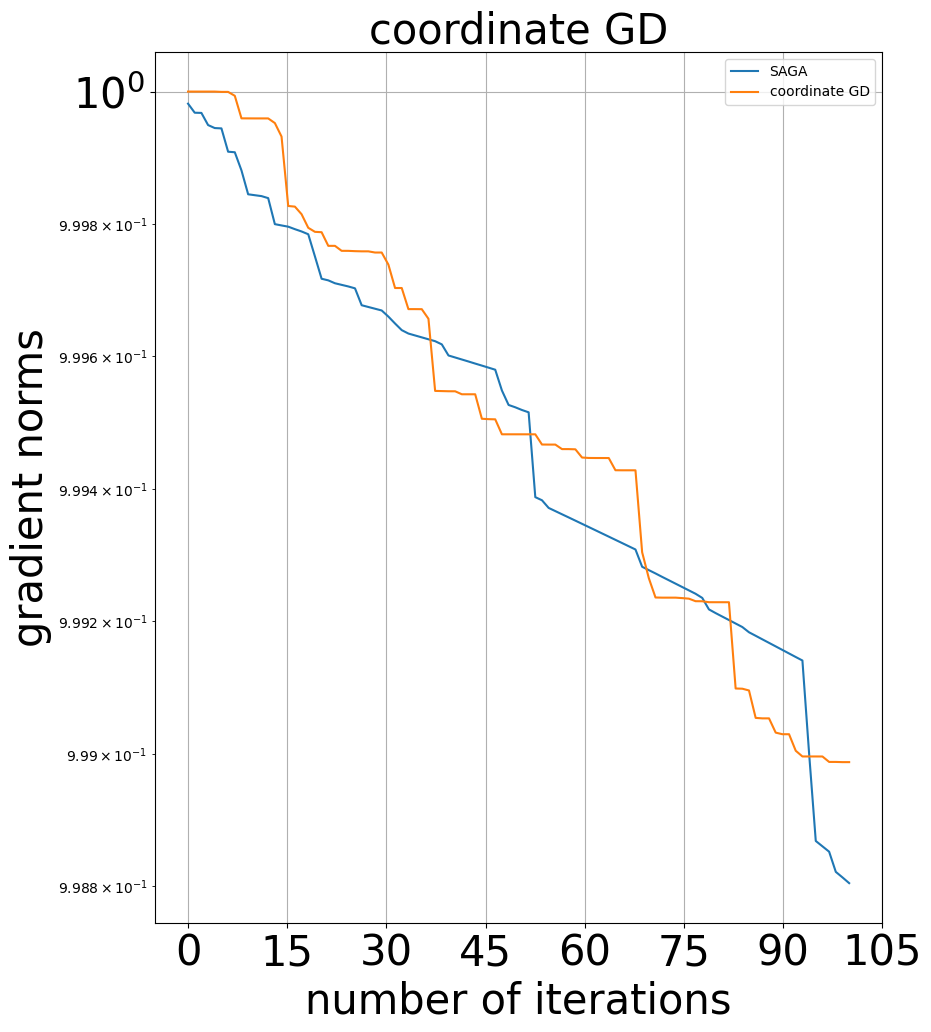

In [1088]:
f,ax1 = plt.subplots(1,figsize = (10,10))
tau = 1e-5
iters = 100

d = omega_0.shape[0]

L = lipschitz_constan(X_train)
lmbd = L / 1000.
gamma = 1 / L / d
omega_0 = np.random.uniform(0, 1, size=X_train.shape[1])



omega, criterions, accuracy, T = SAGA(X, y, omega_0, gamma, lmbd, tau, False, K=iters, eps=1e-5)

plt.plot(np.linspace(0, len(criterions), len(criterions)), criterions, label='SAGA')



omega, criterions, accuracy, T = coordinate_GD(X, y, omega_0, gamma, lmbd, tau, False, K = iters, eps = 1e-5)

plt.plot(np.linspace(0, len(criterions), len(criterions)), criterions, label='coordinate GD')


ax1.grid()
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
ax1.set_xlabel('number of iterations', fontsize = 30 )
ax1.set_ylabel('gradient norms', fontsize = 30 )


ax1.legend(fontsize = 10)


ax1.tick_params(axis='x', labelsize=30)
ax1.tick_params(axis='y', labelsize=30)

plt.tight_layout()

# plt.title('coordinate GD', fontsize = 30)
plt.yscale('log')
plt.show()


Hard to conclude but seems like convergence is more or less the same but SAGA is a bit better

Try to tune the step for the new method. Explain how you determine the tuning strategy. Draw the comparison plot with the new method (step $\frac{1}{dL}$), simple coordinate descent (tuned step and step $\frac{1}{dL}$): value of convergence criterion versus number of iterations. Make a conclusion.

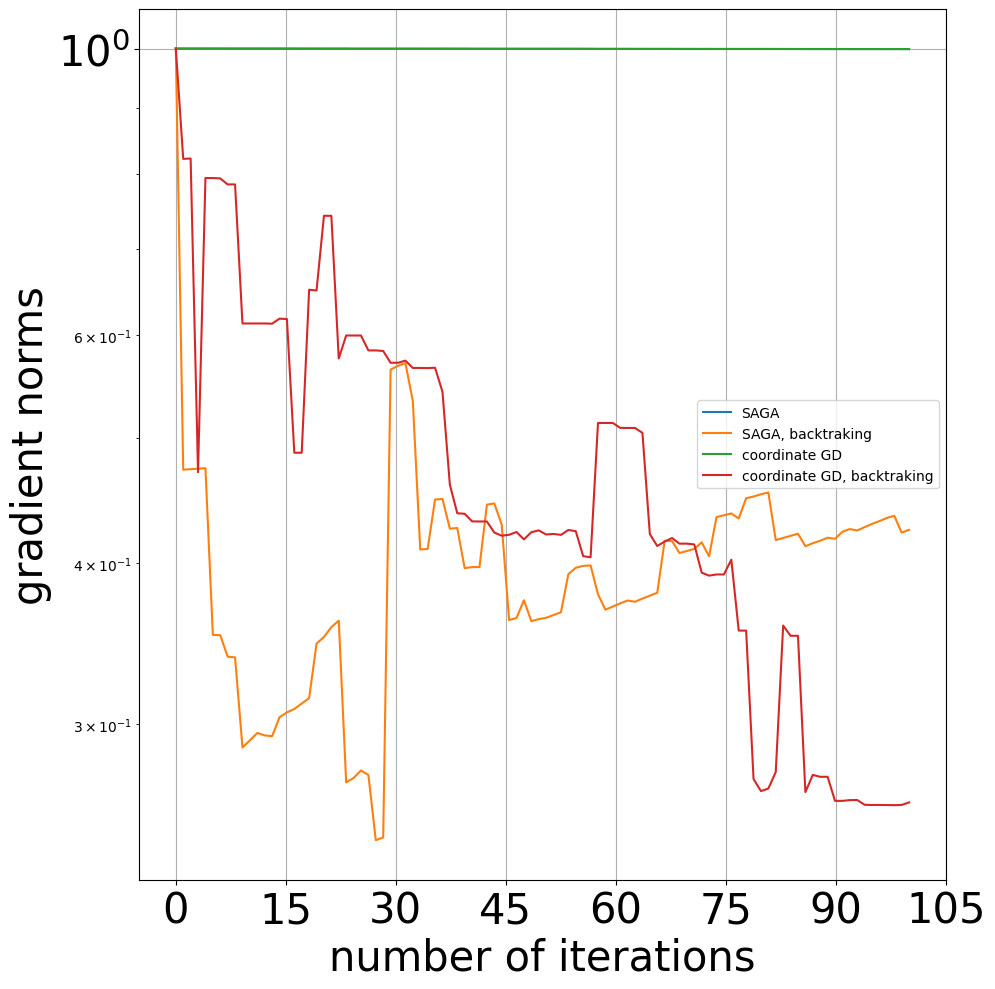

In [1094]:
f,ax1 = plt.subplots(1,figsize = (10,10))
tau = 1e-5
iters = 100

d = omega_0.shape[0]

L = lipschitz_constan(X_train)
lmbd = L / 1000.
gamma = 1 / L / d
omega_0 = np.random.uniform(0, 1, size=X_train.shape[1])



omega, criterions, accuracy, T = SAGA(X, y, omega_0, gamma, lmbd, tau, False, K=iters, eps=1e-5)
plt.plot(np.linspace(0, len(criterions), len(criterions)), criterions, label='SAGA')


omega, criterions, accuracy, T = SAGA(X, y, omega_0, gamma, lmbd, tau, True, K=iters, eps=1e-5)
plt.plot(np.linspace(0, len(criterions), len(criterions)), criterions, label='SAGA, backtraking')


omega, criterions, accuracy, T = coordinate_GD(X, y, omega_0, gamma, lmbd, tau, False, K = iters, eps = 1e-5)
plt.plot(np.linspace(0, len(criterions), len(criterions)), criterions, label='coordinate GD')

omega, criterions, accuracy, T = coordinate_GD(X, y, omega_0, gamma, lmbd, tau, True, K = iters, eps = 1e-5)
plt.plot(np.linspace(0, len(criterions), len(criterions)), criterions, label='coordinate GD, backtraking')


ax1.grid()
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
ax1.set_xlabel('number of iterations', fontsize = 30 )
ax1.set_ylabel('gradient norms', fontsize = 30 )


ax1.legend(fontsize = 10)


ax1.tick_params(axis='x', labelsize=30)
ax1.tick_params(axis='y', labelsize=30)

plt.tight_layout()

# plt.title('coordinate GD', fontsize = 30)
plt.yscale('log')
plt.show()


Again, in order to tune parameters, I implemented backtreking. SAGA with backtraking does not seems stable, coordinate GD with backtraking converges better. Without any stepsize tuning convergense is too slow